## Diffusion lengthscale

Toy model of 1-D diffusion of a linear concentration profile through two layers with different diffusivities. 

Based on lesson 3 of Lorena Barba's CFD Python: 12 Steps to Navier-Stokes (http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/).

We discretize the 1-D diffusion equation

$$\frac{\partial C}{\partial t} = \kappa \frac{\partial^2 C}{\partial z^2}$$

as

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}=\kappa \frac{C_{i+1}^n-2C_i^n+C_{i-1}^n}{\Delta z^2},$$

using forward differences for time and central differences for the spatial derivative.

So, we calculate the concentration at time step n+1 as

$$C_i^{n+1}=\frac{\kappa \Delta t}{\Delta z^2}(C_{i+1}^n-2C_i^n+C_{i-1}^n) + C_i^{n}$$.

I will cheat a litle bit because I will make $\kappa$ variable in time so it should be inside the spatial derivative. Let's see if I can get away with it because it will be a step.


In [27]:
import numpy as np               
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [28]:
# Plots appearance
sns.set_context('notebook')
sns.set_style('whitegrid')

In [29]:
def timestepping(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + (kappa[i] * dt / dz**2 * (un[i+1] - 2 * un[i] + un[i-1]))
    return u

def timesteppingKv(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation with variable Kv
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) 
    u = np.ones(nz) 
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + dt * (((un[i+1] - 2 * un[i] + un[i-1]) / dz**2) + 
                                (((kappa[i+1]-kappa[i-1]) * (un[i+1] + un[i-1])) / (4*dz**2)))
    return u

def smoothHS(nx, xi, epsilon, dx, k1, k2):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx ''' 
    
    hs = np.zeros(nx)
    
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                             (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2
    
    hs[xi+epsilon-1:] = k2+k1
    
    return hs
     
    
def plotICs(IniC,kappa,L,nz):
    '''Plots initial conditions and diffusivity profile, creates figure inside and returns fig and ax handles'''
    fig,(ax1,ax2) = plt.subplots(1,2,sharey = True,figsize=(8,3))

    ax1.plot(IniC, np.linspace(0, L, nz))
    ax1.set_xlabel('Concentration ($\mu M$)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('Initial concentration')

    ax2.plot(kappa,np.linspace(0, L, nz))
    ax2.set_xlabel('$\kappa$ (m$^2$s$^{-1}$)')
    ax2.set_title('Diffusivity profile')
    ax2.invert_yaxis()
    
    return(fig,ax1,ax2)

def plotC(ax, C, L, nz):
    '''Plots concentration over an existing ax and returns ax handle and line handle'''
    ax.axhline(L/2, color='0.8', linestyle='--')
    line, = ax.plot(C, np.linspace(0, L, nz));
    ax.set_xlabel('Concentration ($\mu M$)')
    ax.set_ylabel('Depth (m)')
    return (line)

In [34]:
# INITIALIZATION 

# Space
nz = 200           # number of points in z
L = 100            # total depth (m)
dz = L / (nz - 1)  # vertical spacing (m)

# Time
nt = 44440         # number of timesteps we want to calculate
sigma = .2         #sigma is a parameter, we'll learn more about it later
#dt = sigma * dz**2 / kappa_bg #dt is defined using sigma ... more later!
dt = 30  # time step (s)
to_day = dt/(3600*24)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-3             # canyon diffusivity
kappa = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa[int(nz/2):] = kappa_can

#epsilon = 10
#kappa = smoothHS(nz, 50, epsilon, dz, kappa_bg, kappa_can)

# Talk to me
print('The time step is %1.1f seconds' %dt)
print('The vertical resolution is %1.3f meters' %dz)

The time step is 30.0 seconds
The vertical resolution is 0.503 meters


## Hat profile

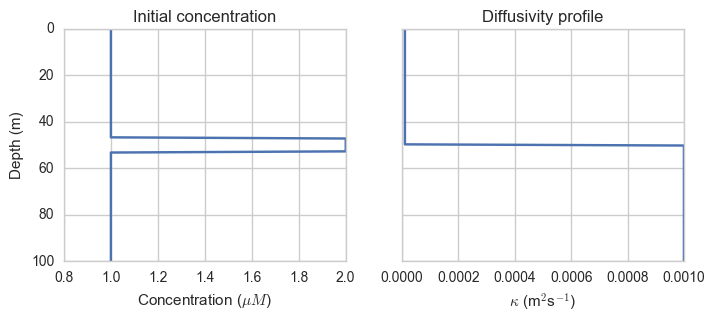

In [35]:
# Initial conditon
IC = np.ones(nz)     
IC[int(nz/2)-6:int(nz/2)+6] = 2  # It's a hat 

fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

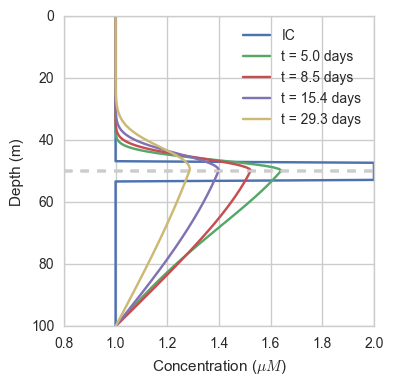

In [36]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [14440,24440,44440,84440]

for time in times:
    conc = timestepping(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', 't = %1.1f days' %(times[0]*to_day),
                    't = %1.1f days' %(times[1]*to_day),
                    't = %1.1f days' %(times[2]*to_day),
                    't = %1.1f days'%(times[3]*to_day))) 

## Parabolic profile

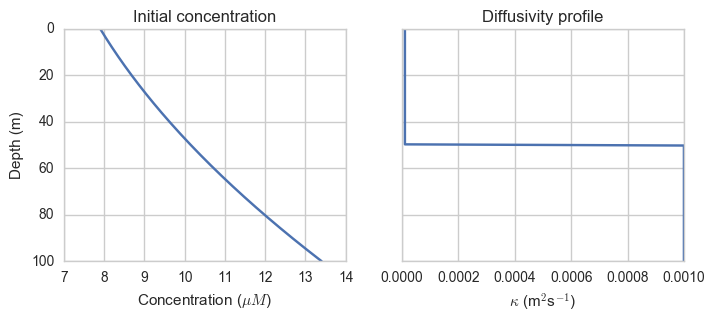

In [37]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.0002*(ii*dz)**2+0.035*ii*dz+7.9

fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

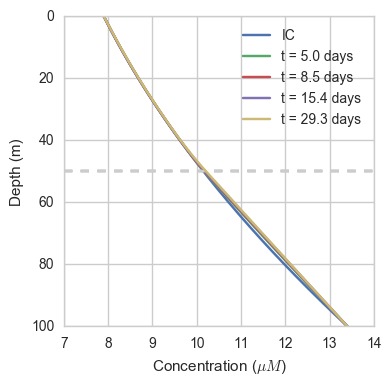

In [38]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [14440,24440,44440,84440]

for time in times:
    conc = timestepping(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', 't = %1.1f days' %(times[0]*to_day),'t = %1.1f days' %(times[1]*to_day),
                     't = %1.1f days' %(times[2]*to_day),'t = %1.1f days'%(times[3]*to_day))) 

## Linear profile

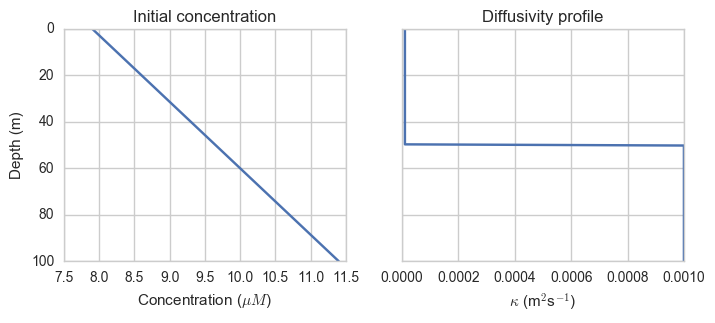

In [39]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9
    
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

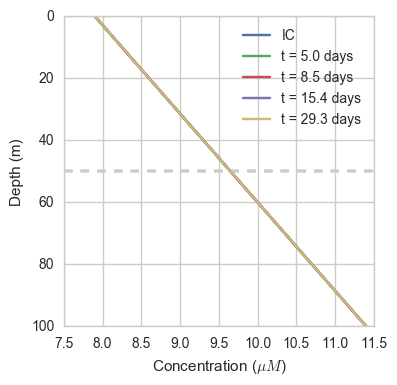

In [40]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [14440,24440,44440,84440]

for time in times:
    conc = timestepping(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', 't = %1.1f days' %(times[0]*to_day),'t = %1.1f days' %(times[1]*to_day),
                     't = %1.1f days' %(times[2]*to_day),'t = %1.1f days'%(times[3]*to_day))) 

I tried a max of 84440 (10x the largest nt but nothing happened)

# Kappa varies in space, so add derivative

In [43]:
# Smoothed Heaviside function for diffusivity
epsilon = 10
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

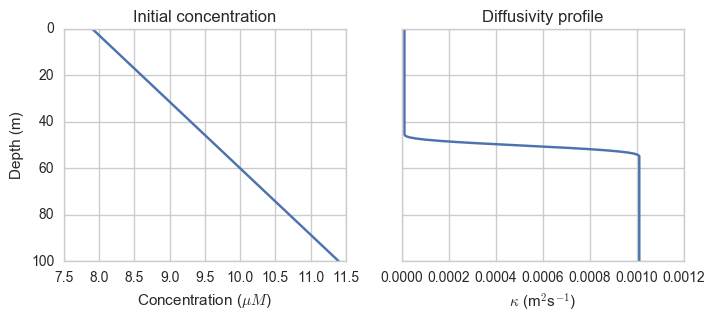

In [44]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9
    
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

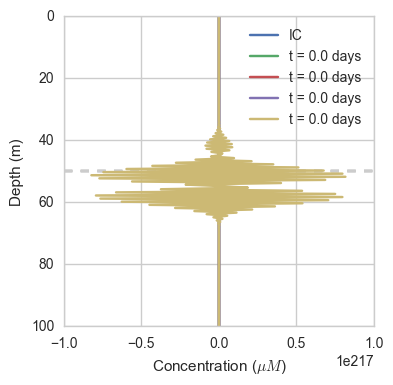

In [45]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [14,24,44,84]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', 't = %1.1f days' %(times[0]*to_day),'t = %1.1f days' %(times[1]*to_day),
                     't = %1.1f days' %(times[2]*to_day),'t = %1.1f days'%(times[3]*to_day))) 

In [49]:
# Smoothed Heaviside function for diffusivity
epsilon = 60
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

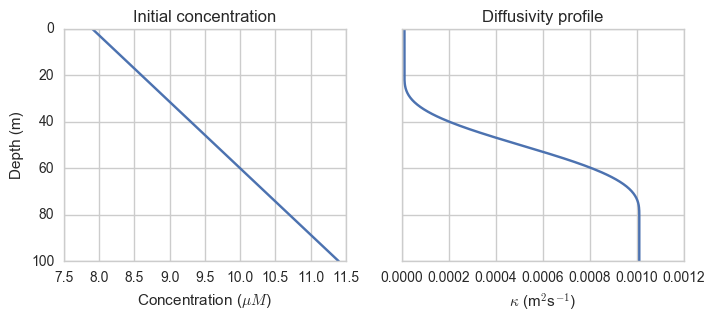

In [50]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9
    
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

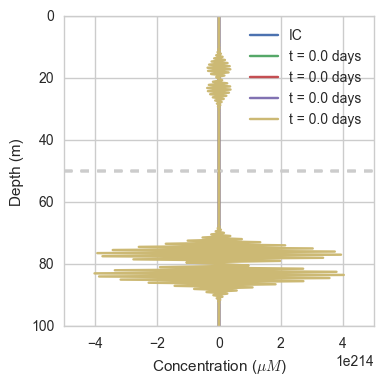

In [51]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [14,24,44,84]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', 't = %1.1f days' %(times[0]*to_day),'t = %1.1f days' %(times[1]*to_day),
                     't = %1.1f days' %(times[2]*to_day),'t = %1.1f days'%(times[3]*to_day))) 